# Lab 5: Exercise solutions

In [1]:
with open('../course/common.py') as fin:
    exec(fin.read())

In [2]:
with open('../course/matplotlibconf.py') as fin:
    exec(fin.read())

## Exercise 1

You've just started to work at a wine company, and they would like you to help them build a model that predicts the quality of their wine based on several measurements. They give you a dataset with wine:

- load the ../data/wines.csv into Pandas
- use the column called "Class" as the target
- check how many classes are there in the target, and if necessary use dummy columns for a Multiclass classification
- use all the other columns as features, check their range and distribution (using seaborn pairplot)
- rescale all the features using either MinMaxScaler or StandardScaler
- build a deep model with at least one hidden layer to classify the data
- choose the cost function, what will you use? Mean Squared Error? Binary Cross-Entropy? Categorical Cross-Entropy?
- choose an optimizer
- choose a value for the learning rate. You may want to try with several values
- choose a batch size
- train your model on all the data using a `validation_split=0.2`. Can you converge to 100% validation accuracy?
- what's the minimum number of epochs to converge?
- repeat the training several times to verify how stable your results are

In [3]:
df = pd.read_csv('../data/wines.csv')

In [4]:
df.head()

,Class,Alcohol,Malic_acid,Ash,...,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,...,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,...,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,...,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,...,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,...,4.32,1.04,2.93,735


In [5]:
y = df['Class']

In [6]:
y.value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [7]:
y_cat = pd.get_dummies(y)

In [8]:
y_cat.head()

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [9]:
X = df.drop('Class', axis=1)

In [10]:
X.shape

(178, 13)

In [11]:
import seaborn as sns

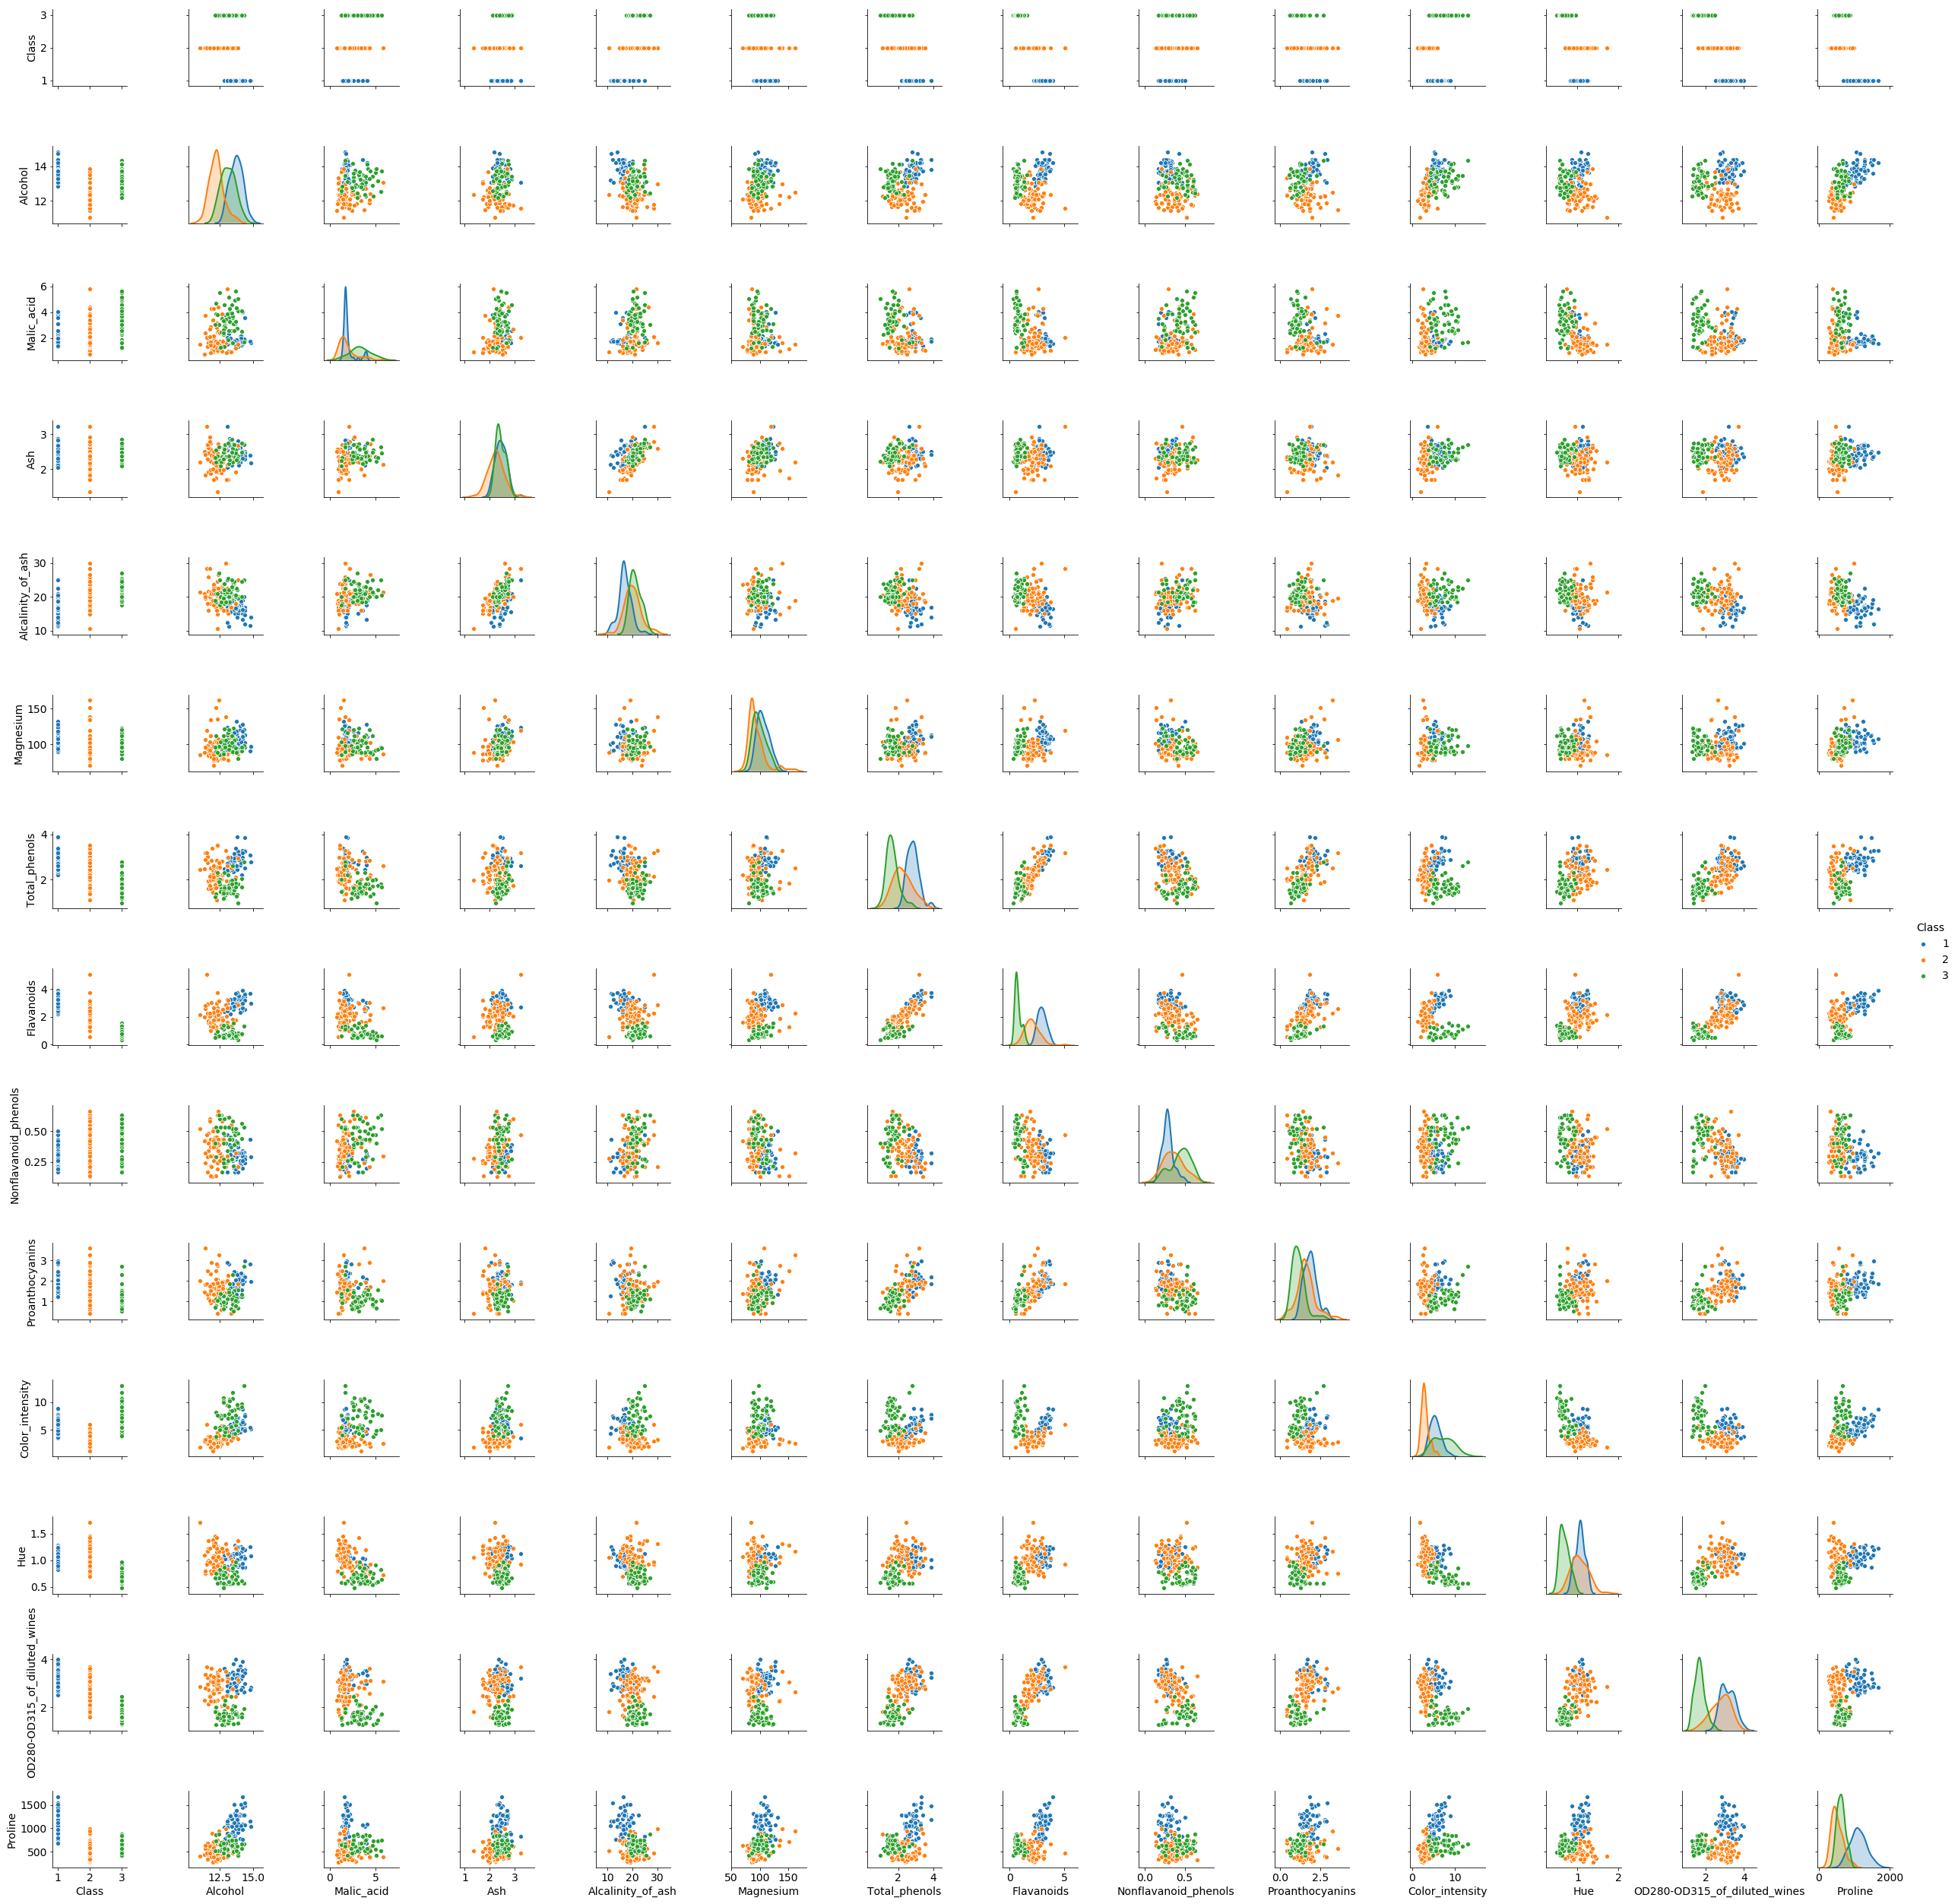

In [12]:
sns.pairplot(df, hue='Class')

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
sc = StandardScaler()

In [15]:
Xsc = sc.fit_transform(X)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
import tensorflow.keras.backend as K

In [17]:
K.clear_session()
model = Sequential()
model.add(Dense(5, input_shape=(13,),
                kernel_initializer='he_normal',
                activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(RMSprop(lr=0.1),
              'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(Xsc, y_cat.values,
          batch_size=8,
          epochs=10,
          verbose=0,
          validation_split=0.2);

## Exercise 2

Since this dataset has 13 features, we can only visualize pairs of features as we did in the pairplot. We could, however, exploit the fact that a Neural Network is a function to extract two high-level features to represent our data.

- build a deep fully connected network with the following structure:
    - Layer 1: 8 nodes
    - Layer 2: 5 nodes
    - Layer 3: 2 nodes
    - Output: 3 nodes
- choose activation functions, initializations, optimizer, and learning rate so that it converges to 100% accuracy within 20 epochs (not easy)
- remember to train the model on the scaled data
- define a Feature Function as we did above between the input of the 1st layer and the output of the 3rd layer
- calculate the features and plot them on a 2-dimensional scatter plot
- can we distinguish the three classes well?

In [18]:
K.clear_session()
model = Sequential()
model.add(Dense(8, input_shape=(13,),
                kernel_initializer='he_normal',
                activation='tanh'))
model.add(Dense(5, kernel_initializer='he_normal',
                activation='tanh'))
model.add(Dense(2, kernel_initializer='he_normal',
                activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(RMSprop(lr=0.05),
              'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(Xsc, y_cat.values,
          batch_size=16,
          epochs=20,
          verbose=0);

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [20]:
inp = model.layers[0].input
out = model.layers[2].output

In [21]:
features_function = K.function([inp], [out])

In [22]:
features = features_function([Xsc])[0]

In [23]:
features.shape

(178, 2)

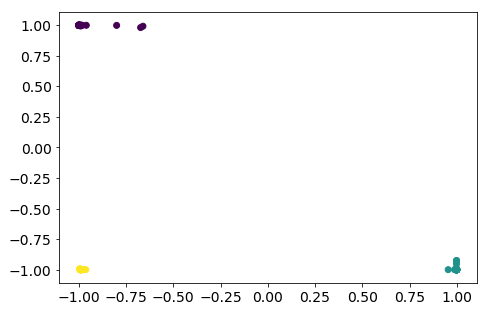

In [24]:
plt.scatter(features[:, 0], features[:, 1], c=y);

## Exercise 3

Keras functional API. So far we've always used the Sequential model API in Keras. However, Keras also offers a Functional API, which is much more powerful. You can find its [documentation here](https://keras.io/getting-started/functional-api-guide/). Let's see how we can leverage it.

- define an input layer called `inputs`
- define two hidden layers as before, one with eight nodes, one with five nodes
- define a `second_to_last` layer with 2 nodes
- define an output layer with three nodes
- create a model that connects input and output
- train it and make sure that it converges
- define a function between inputs and second_to_last layer
- recalculate the features and plot them

In [25]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [26]:
K.clear_session()

inputs = Input(shape=(13,))
x = Dense(8, kernel_initializer='he_normal',
          activation='tanh')(inputs)
x = Dense(5, kernel_initializer='he_normal',
          activation='tanh')(x)
second_to_last = Dense(2, kernel_initializer='he_normal',
                       activation='tanh')(x)
outputs = Dense(3, activation='softmax')(second_to_last)

model = Model(inputs=inputs, outputs=outputs)

model.compile(RMSprop(lr=0.05),
              'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(Xsc, y_cat.values, batch_size=16,
          epochs=20, verbose=0);

In [27]:
features_function = K.function([inputs], [second_to_last])

In [28]:
features = features_function([Xsc])[0]

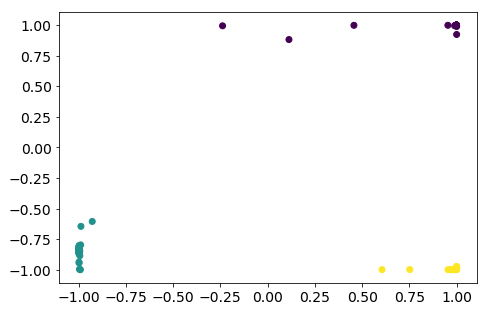

In [29]:
plt.scatter(features[:, 0], features[:, 1], c=y);

## Exercise 4

Keras offers the possibility to call a function at each epoch. These are Callbacks, and their [documentation is here](https://keras.io/callbacks/). Callbacks allow us to add some neat functionality. In this exercise, we'll explore a few of them.

- Split the data into train and test sets with a test_size = 0.3 and random_state=42
- Reset and recompile your model
- train the model on the train data using `validation_data=(X_test, y_test)`
- Use the `EarlyStopping` callback to stop your training if the `val_loss` doesn't improve
- Use the `ModelCheckpoint` callback to save the trained model to disk once training is over
- Use the `TensorBoard` callback to output your training information to a `/tmp/` subdirectory

You can use tensorboard in the notebook by running the following two commands:

```python
%load_ext tensorboard.notebook

%tensorboard --logdir /tmp/ztdlbook/tensorboard/
```

You can also run tensorboard in a separate terminal with the command:

```bash
tensorboard --logdir /tmp/ztdl/tensorboard/
```
and then open another browser window at address: http://localhost:6006.

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

In [31]:
checkpointer = ModelCheckpoint(
    filepath="/tmp/ztdlbook/weights.hdf5",
    verbose=1, save_best_only=True)

In [32]:
earlystopper = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1,
    verbose=1, mode='auto')

In [33]:
tensorboard = TensorBoard(
    log_dir='/tmp/ztdlbook/tensorboard/')

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = \
    train_test_split(Xsc, y_cat.values,
                     test_size=0.3, random_state=42)

In [36]:
K.clear_session()

inputs = Input(shape=(13,))

x = Dense(8, kernel_initializer='he_normal',
          activation='tanh')(inputs)

x = Dense(5, kernel_initializer='he_normal',
          activation='tanh')(x)

second_to_last = Dense(2, kernel_initializer='he_normal',
                       activation='tanh')(x)

outputs = Dense(3, activation='softmax')(second_to_last)

model = Model(inputs=inputs, outputs=outputs)

model.compile(RMSprop(lr=0.05),
              'categorical_crossentropy',
              metrics=['accuracy'])

callbacks_ = [checkpointer, earlystopper, tensorboard]

model.fit(X_train, y_train, batch_size=32,
          epochs=20, verbose=0,
          validation_data=(X_test, y_test),
          callbacks=callbacks_);


Epoch 00001: val_loss improved from inf to 0.79879, saving model to /tmp/ztdlbook/weights.hdf5

Epoch 00002: val_loss improved from 0.79879 to 0.53124, saving model to /tmp/ztdlbook/weights.hdf5

Epoch 00003: val_loss improved from 0.53124 to 0.44048, saving model to /tmp/ztdlbook/weights.hdf5

Epoch 00004: val_loss improved from 0.44048 to 0.28921, saving model to /tmp/ztdlbook/weights.hdf5

Epoch 00005: val_loss improved from 0.28921 to 0.22405, saving model to /tmp/ztdlbook/weights.hdf5

Epoch 00006: val_loss did not improve from 0.22405
Epoch 00006: early stopping


To run Tensorboard uncomment the next two cells

In [37]:
# %load_ext tensorboard.notebook

In [38]:
# %tensorboard --logdir /tmp/ztdlbook/tensorboard/